# HPA Usage
Pesquisa por código no Github, buscando por arquivos que contenham definições de HPA (HorizontalPodAutoscaler).

Filtra por repositórios com alguma relevância (número de estrelas) e apresenta estatísticas.

Os arquivos encontrados após o filtro são salvos no diretório `search_results`.

## Preparando o ambiente

In [2]:
import os
import glob
import time
import re
import json
import requests
import yaml
from datetime import datetime
from joblib import Parallel, delayed
from dotenv import dotenv_values
from ghapi.core import GhApi, HTTP422UnprocessableEntityError
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import utils

In [3]:
config = {
  **os.environ,
  **dotenv_values(".env")
}
github = GhApi(token=config['GITHUB_TOKEN'])

In [6]:
gh_limit = github.rate_limit.get()

print(datetime.timestamp(datetime.now()))
display(gh_limit['resources'])

1740082659.853971


```json
{ 'actions_runner_registration': { 'limit': 10000,
                                   'remaining': 10000,
                                   'reset': 1740086195,
                                   'used': 0},
  'audit_log': { 'limit': 1750,
                 'remaining': 1750,
                 'reset': 1740086195,
                 'used': 0},
  'audit_log_streaming': { 'limit': 15,
                           'remaining': 15,
                           'reset': 1740086195,
                           'used': 0},
  'code_scanning_autofix': { 'limit': 10,
                             'remaining': 10,
                             'reset': 1740082655,
                             'used': 0},
  'code_scanning_upload': { 'limit': 1000,
                            'remaining': 1000,
                            'reset': 1740086195,
                            'used': 0},
  'code_search': {'limit': 10, 'remaining': 10, 'reset': 1740082655, 'used': 0},
  'core': {'limit': 5000, 'remaining': 5000, 'reset': 1740086195, 'used': 0},
  'dependency_snapshots': { 'limit': 100,
                            'remaining': 100,
                            'reset': 1740082655,
                            'used': 0},
  'graphql': {'limit': 5000, 'remaining': 5000, 'reset': 1740086195, 'used': 0},
  'integration_manifest': { 'limit': 5000,
                            'remaining': 5000,
                            'reset': 1740086195,
                            'used': 0},
  'scim': {'limit': 15000, 'remaining': 15000, 'reset': 1740086195, 'used': 0},
  'search': {'limit': 30, 'remaining': 30, 'reset': 1740082655, 'used': 0},
  'source_import': { 'limit': 100,
                     'remaining': 100,
                     'reset': 1740082655,
                     'used': 0}}
```

## Definindo Funções Principais

In [7]:
def search_code_hpa():
  """
  Realiza a pesquisa por arquivos de código contendo definição de um HPA ("kind: HorizontalPodAutoscaler")
  
  Por limitação da API, a cada pesquisa, um máximo de 1000 itens será retornado.
  """
  result_items = []
  page = 1

  # search_result acumula cada página da pesquisa
  search_result = None

  # Carrega as páginas da pesquisa
  while search_result is None or len(result_items) < search_result['total_count']:
    rate_remaining = github.rate_limit.get()['resources']['code_search']['remaining']
    if rate_remaining <= 1:
      time.sleep(1)
      continue
    print(f"Carregando página {page}")
    time.sleep(1)
    try:
      search_result = github.search.code(q='"kind: HorizontalPodAutoscaler" language:yaml', per_page=100, page=page)
      result_items.extend(search_result['items'])
      page += 1
    except HTTP422UnprocessableEntityError as e:
      return result_items


def get_repo_details(repo_name):
  name_parts = re.split(r'/', repo_name)
  while github.rate_limit.get()['resources']['core']['remaining'] <= 0:
    time.sleep(1)
  repo_details = github.repos.get(owner=name_parts[0], repo=name_parts[1])
  return {
    'stargazers_count': repo_details['stargazers_count'],
    'created_at': repo_details['created_at'],
    'pushed_at': repo_details['pushed_at']
  }


def extract_hpa(yaml_content):
  hpa_list = []
  for doc in yaml_content:
    if isinstance(doc, dict) and doc.get('kind') == "HorizontalPodAutoscaler":
      hpa_list.append(doc)
  return hpa_list


def download_hpa_spec(item):
  if not os.path.isdir('search_results'):
    os.mkdir('search_results')

  print(f"Downloading {item['url']}")
  response = requests.get(item['url'])
  if response.status_code == 200:

    # Remove marcações de template Helm
    clean_text = re.sub(r'{{-.*?}}', '', response.text)
    clean_text = re.sub(r'{{.*?}}', 'helm_command', clean_text)

    yaml_content = list(yaml.safe_load_all(clean_text))
    hpa_content = extract_hpa(yaml_content)
    if hpa_content is None:
      return

    target_path = os.path.join("search_results", item['repo_name'], item['file_path'])
    target_dir = os.path.dirname(target_path)
    os.makedirs(target_dir, exist_ok=True)
    
    with open(target_path, 'w') as file:
      file.write(yaml.dump_all(hpa_content))
  else:
    print(f"Loading {url} returned {response.status_code}")

def download_file(url, repo_name, file_path):
  if not os.path.isdir('search_results'):
    os.mkdir('search_results')
  
  response = requests.get(url.replace('/blob/', '/raw/'))
  if response.status_code == 200:
    target_path = os.path.join("search_results", repo_name, file_path)
    target_dir = os.path.dirname(target_path)
    os.makedirs(target_dir, exist_ok=True)
    with open(target_path, 'w') as file:
      file.write(response.text)
  else:
    print(f'Loading {url} returned {response.status_code}')
    

# Realiza a Pesquisa

In [ ]:
search_items = []
result_items = search_code_hpa()
for item in result_items:
  search_items.append({
    'repo_name': item['repository']['full_name'],
    'file_path': item['path'],
    'url': item['html_url']
  })


Carregando página 1
Carregando página 2
Carregando página 3
Carregando página 4
Carregando página 5
Carregando página 6
Carregando página 7
Carregando página 8
Carregando página 9


In [14]:
items = pd.DataFrame(search_items)

display(items)
print(f"Encontrados {items.shape[0]} arquivos em {len(items['repo_name'].unique())} repositórios")


,repo_name,file_path,url
0,learnk8s/spring-boot-k8s-hpa,kube/hpa.yaml,https://github.com/learnk8s/spring-boot-k8s-hp...
1,krestomatio/moodle-operator,watches.yaml,https://github.com/krestomatio/moodle-operator...
2,ChandanTeekinavar/flask-mongo_db,hpa.yml,https://github.com/ChandanTeekinavar/flask-mon...
3,devopsbykunal/Modern-Restaurant-UI-main,deploy.yaml,https://github.com/devopsbykunal/Modern-Restau...
4,Yuvaraj2002/capstone-project,my-hpa.yaml,https://github.com/Yuvaraj2002/capstone-projec...
...,...,...,...
995,crstn07/SO1_1S2024_202010893,Proyecto2/k8s/hpa.yaml,https://github.com/crstn07/SO1_1S2024_20201089...
996,steblynskyi/infrastructure,environments/qa/kubernetes/services/pms/folio-...,https://github.com/steblynskyi/infrastructure/...
997,LTKH/minikube,charts/alerttrap/templates/hpa.yaml,https://github.com/LTKH/minikube/blob/defa71db...
998,thefron/hangul_ipsum,deploy/hangul-ipsum/templates/hpa.yaml,https://github.com/thefron/hangul_ipsum/blob/9...


Encontrados 1000 arquivos em 896 repositórios


## Salva Fase 1 da Pesquisa

In [ ]:
utils.save_results(items)

## Carrega todas as Pesquisas Anteriores

In [ ]:
items = utils.load_results()

print(f"Encontrados {items.shape[0]} arquivos em {len(items['repo_name'].unique())} repositórios")

Encontrados 3179 arquivos em 2579 repositórios


## Número de Estrelas

In [143]:
repo_names = items['repo_name'].tolist()

repos_details = Parallel(n_jobs=4)(
  delayed(get_repo_details)(repo_name) for repo_name in repo_names
)

df_details = pd.DataFrame(repos_details)

In [144]:
display(df_details)

,stargazers_count,created_at,pushed_at
0,401,2020-02-24T22:19:26Z,2025-02-12T11:15:29Z
1,15,2020-07-25T20:39:12Z,2025-02-07T18:21:53Z
2,0,2021-04-01T09:33:42Z,2022-03-11T18:11:05Z
3,22,2019-03-09T00:40:19Z,2023-01-23T18:28:12Z
4,0,2024-11-17T16:01:43Z,2024-11-19T00:02:01Z
...,...,...,...
2198,7,2024-05-11T16:30:56Z,2025-02-07T17:06:29Z
2199,2,2022-05-05T17:41:00Z,2022-09-24T02:27:41Z
2200,2,2021-09-25T02:05:20Z,2024-04-11T00:28:10Z
2201,4,2020-09-21T13:47:22Z,2021-01-12T19:02:12Z


In [ ]:
items_details = items.join(df_details)

display(items_details)

,repo_name,file_path,url,stargazers_count,created_at,pushed_at
0,fluent/helm-charts,charts/fluentd/templates/hpa.yaml,https://github.com/fluent/helm-charts/blob/f87...,401,2020-02-24T22:19:26Z,2025-02-12T11:15:29Z
1,krestomatio/moodle-operator,watches.yaml,https://github.com/krestomatio/moodle-operator...,15,2020-07-25T20:39:12Z,2025-02-07T18:21:53Z
2,andrewferguson/corekube-worker,full.yaml,https://github.com/andrewferguson/corekube-wor...,0,2021-04-01T09:33:42Z,2022-03-11T18:11:05Z
3,carvel-dev/ytt-library-for-kubernetes,app/hpa.yml,https://github.com/carvel-dev/ytt-library-for-...,22,2019-03-09T00:40:19Z,2023-01-23T18:28:12Z
4,rafaelongo45/k8s-guess-game,api.yaml,https://github.com/rafaelongo45/k8s-guess-game...,0,2024-11-17T16:01:43Z,2024-11-19T00:02:01Z
...,...,...,...,...,...,...
995,Intuinewin/helm-charts,firezone/templates/domain/hpa.yaml,https://github.com/Intuinewin/helm-charts/blob...,0,2021-08-18T16:30:06Z,2024-02-15T00:05:33Z
996,Dobry-kot/kubernetes,helmCluster/templates/hpa.yaml,https://github.com/Dobry-kot/kubernetes/blob/1...,0,2024-02-27T21:32:28Z,2025-01-13T02:46:08Z
997,theboarderline/helm-charts,charts/web-app/templates/hpa.yaml,https://github.com/theboarderline/helm-charts/...,0,2020-05-26T15:29:52Z,2020-05-26T15:30:57Z
998,J0hn-B/eshop,services/payment/templates/payment-hpa.yaml,https://github.com/J0hn-B/eshop/blob/514514710...,2,2019-05-04T19:20:07Z,2022-11-22T03:33:43Z


In [155]:
print("Todos os resultados")
print(items_details['stargazers_count'].describe())

min_stars = 1
print(f"\nPelo menos {min_stars} estrelas")
filter_min_stars = items_details[items_details['stargazers_count'] > min_stars]
print(filter_min_stars['stargazers_count'].describe())

print("\nPercentil > 0.9 estrelas")
filter_outliers_items = items_details[items_details['stargazers_count'] >= items_details['stargazers_count'].quantile(0.90)]
print(filter_outliers_items['stargazers_count'].describe())


Todos os resultados
count     2203.000000
mean       183.354517
std       1763.532629
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max      29496.000000
Name: stargazers_count, dtype: float64

Pelo menos 1 estrelas
count      578.000000
mean       698.366782
std       3392.438939
min          2.000000
25%          3.000000
50%         10.000000
75%         63.000000
max      29496.000000
Name: stargazers_count, dtype: float64

Percentil > 0.9 estrelas
count      221.000000
mean      1816.316742
std       5305.777889
min         23.000000
25%         40.000000
50%        116.000000
75%        665.000000
max      29496.000000
Name: stargazers_count, dtype: float64


In [156]:
len(filter_min_stars['repo_name'].unique())

511

Text(0.5, 1.0, 'Histograma Repo Stars > 1')

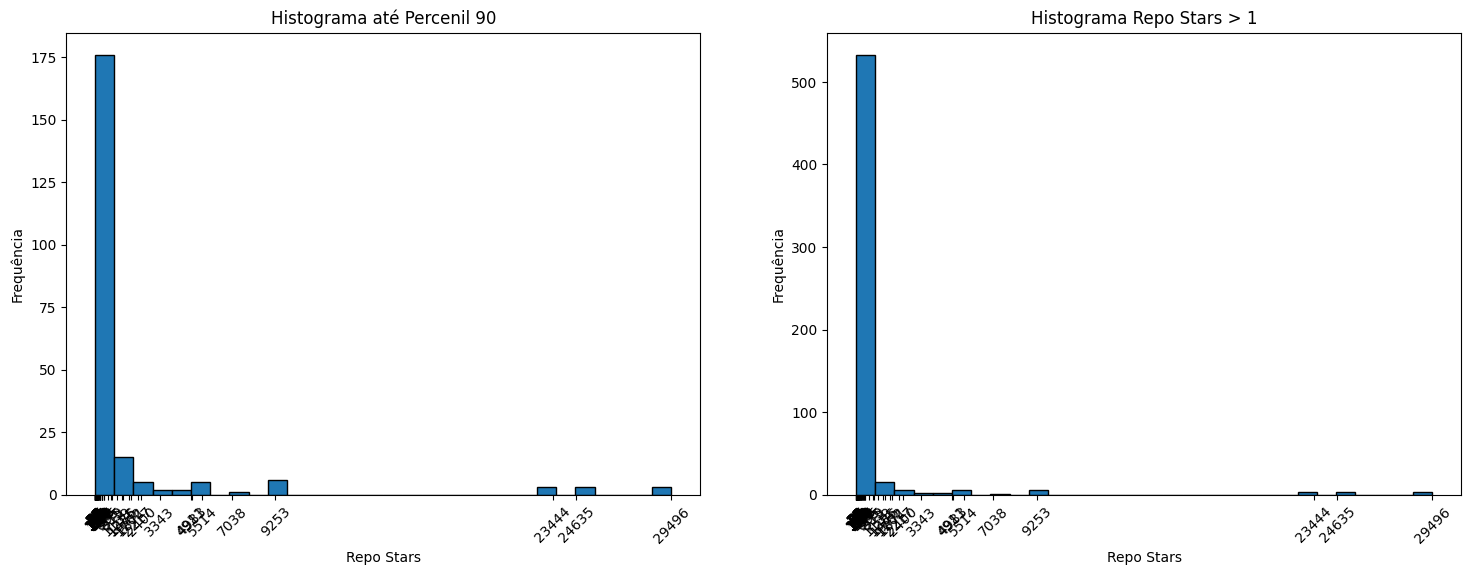

In [160]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
bins=30
# bins = np.concatenate((np.linspace(0, 50, 20), np.linspace(50, filter_outliers_items['stargazers_count'].max(), 10)))

axes[0].hist(filter_outliers_items['stargazers_count'], bins=bins, edgecolor='black')
axes[0].set_xlabel("Repo Stars")
axes[0].set_ylabel("Frequência")
axes[0].set_title("Histograma até Percenil 90")
axes[0].set_xticks(filter_outliers_items['stargazers_count'].unique())
axes[0].tick_params(axis="x", rotation=45)
axes[1].hist(filter_min_stars['stargazers_count'], bins=bins, edgecolor='black')
axes[1].set_xlabel("Repo Stars")
axes[1].set_ylabel("Frequência")
axes[1].set_xticks(filter_outliers_items['stargazers_count'].unique())
axes[1].tick_params(axis="x", rotation=45)
axes[1].set_title(f"Histograma Repo Stars > {min_stars}")

In [161]:
filtered_items = filter_min_stars.sort_values(by=['stargazers_count'])
filtered_items

,repo_name,file_path,url,stargazers_count,created_at,pushed_at
998,J0hn-B/eshop,services/payment/templates/payment-hpa.yaml,https://github.com/J0hn-B/eshop/blob/514514710...,2,2019-05-04T19:20:07Z,2022-11-22T03:33:43Z
974,steblynskyi/infrastructure,environments/prod/kubernetes/services/utils/pr...,https://github.com/steblynskyi/infrastructure/...,2,2024-09-24T16:28:08Z,2025-02-17T17:25:13Z
949,jrbockrath/james_gc_repo,swsystem-draft-calendar/apps/app1/helm/templat...,https://github.com/jrbockrath/james_gc_repo/bl...,2,2024-09-21T12:26:59Z,2025-01-06T07:03:54Z
164,skonto/serverless-guides,OSSM/1_34/must-gather.local.239218467324331573...,https://github.com/skonto/serverless-guides/bl...,2,2023-03-03T19:11:13Z,2025-01-23T11:31:17Z
561,WilliamDenniss/kubernetes-for-developers,Chapter06/6.2_HPA/hpa.yaml,https://github.com/WilliamDenniss/kubernetes-f...,2,2020-03-13T14:44:48Z,2021-03-30T10:47:29Z
...,...,...,...,...,...,...
405,klebeer/code-challenge,devOps/flux/apps/base/backend-api.yaml,https://github.com/klebeer/code-challenge/blob...,24635,2018-04-16T09:22:48Z,2025-02-17T17:04:25Z
405,grafana/loki,production/helm/loki/templates/querier/hpa.yaml,https://github.com/grafana/loki/blob/8fd8697b9...,24635,2018-04-16T09:22:48Z,2025-02-17T17:04:25Z
124,transloadit/uppy,packages/@uppy/companion/infra/kube/companion/...,https://github.com/transloadit/uppy/blob/4f045...,29496,2015-11-16T12:32:33Z,2025-02-17T14:09:27Z
124,Sohamnimbalkar07/100xDevs-Cohort,kubernetes/horizontal-pod-autoscaler.yml,https://github.com/Sohamnimbalkar07/100xDevs-C...,29496,2015-11-16T12:32:33Z,2025-02-17T14:09:27Z


In [27]:
def prepare_csv(item):
  owner_repo = re.split(pattern=r'/', string=item['repo_name'])
  return pd.Series({
    'owner': owner_repo[0],
    'repo': owner_repo[1],
    'path': item['file_path']
  })

csv_prepared = filter_min_stars.apply(prepare_csv, axis=1)
csv_prepared.to_csv('extract.csv')


In [168]:
urls = items['url'].tolist()
repo_names = items['repo_name'].tolist()
file_paths = items['file_path'].tolist()

Parallel(n_jobs=4)(
  delayed(download_file)(url, repo_name, file_path)
  for url, repo_name, file_path in zip(urls, repo_names, file_paths)
)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,